In [2]:
# import tifffile as tf
from dask_image.imread import imread
import matplotlib.pyplot as plt
use_gpu = True
if use_gpu:
    from cucim.skimage.morphology import white_tophat, disk
    import cupy as xp
    print("Using cucim")
else:
    from skimage.morphology import white_tophat, disk
    import numpy as xp
    print("Using skimage")
from tqdm import tqdm

Using cucim


In [3]:
root = "/lustre/scratch126/cellgen/team283/tl10/EMBL_training/training/decoding/"

In [6]:
# Lazily load the image
registered_stack = imread(f"{root}/in/demo_optflow_seg_optflow_reg_result_stack.tif")

In [8]:
registered_stack.shape # (c, y, x), 35 channels of 4114 * 4369 images

(35, 4114, 4369)

In [10]:
anchor_ch = registered_stack[1]
anchor_ch
print("Anchor image shape: ", anchor_ch.shape)
print("Channel 1-5 are empty channels, not used for decoding")
coding_chs = registered_stack[
    [6,7,8,9,
     11,12,13,14,
     16,17,18,19,
     21,22,23,24,
     26,27,28,29,
     31,32,33,34]]
print("Coding image shape: ", coding_chs.shape)

Anchor image shape:  (4114, 4369)
Channel 1-5 are empty channels, not used for decoding
Coding image shape:  (24, 4114, 4369)


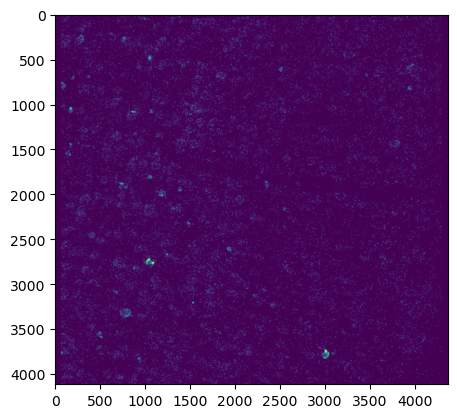

In [12]:
plt.imshow(anchor_ch) # TODO: Napari vis.

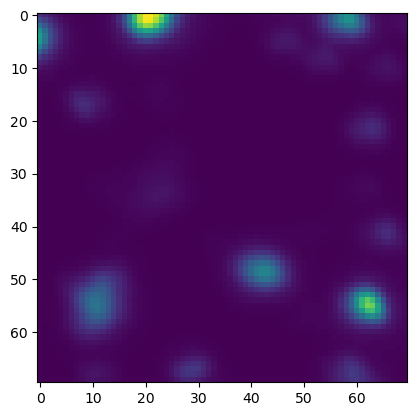

In [7]:
plt.imshow(anchor_ch[80:150, 80:150]) # TODO: Napari vis.

In [13]:
spot_diam = 5 # manually count the spot diameter. Roughly 5 pixels.

In [14]:
selem=disk(spot_diam/2) # Create the kernel for white tophat filtering

In [15]:
selem # TODO: Napari vis.

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0]], dtype=uint8)

In [17]:
enhancded = []
for ch in tqdm(coding_chs): # Run the white tophat filter on all coding channels
    enhancded.append(white_tophat(xp.array(ch), footprint=selem))

100%|██████████| 24/24 [00:01<00:00, 14.58it/s]


In [18]:
enhanced_stack = xp.array(enhancded)

In [22]:
enhancded_anchor = white_tophat(xp.array(anchor_ch), footprint=selem) # Run the white tophat filter on the anchor channel

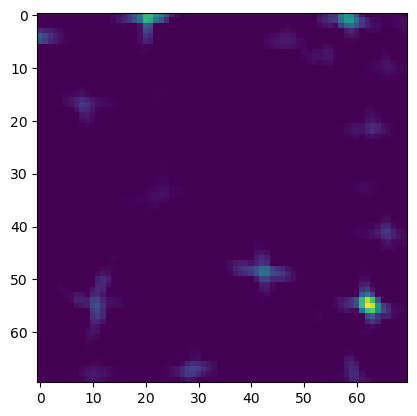

In [23]:
plt.imshow(enhancded_anchor[80:150, 80:150].get()) # TODO napri vis.

In [28]:
import trackpy as tp
import numpy as np

In [33]:
spots = tp.locate(np.array(enhancded_anchor.get()), spot_diam, separation=3, percentile=98) # Find the spots in the anchor channel

In [34]:
spots

,y,x,mass,size,ecc,signal,raw_mass,ep
0,2.241803,829.713764,15024.569562,1.187879,0.259268,2668.795951,85998.0,0.001909
1,1.868121,969.936389,12287.003071,1.097451,0.053729,2658.191877,75665.0,0.002170
2,2.107483,2087.951080,8829.918963,1.103736,0.108249,1890.332156,56351.0,0.002914
3,2.226025,2861.095298,12218.700358,1.132915,0.184553,2313.091641,72412.0,0.002267
4,1.868101,2979.977116,17540.386149,1.068302,0.144755,3770.216180,100182.0,0.001639
...,...,...,...,...,...,...,...,...
19563,4110.591112,554.151063,14682.432229,1.193925,0.163194,2490.709882,76639.0,0.002142
19564,4110.858709,1043.694682,23588.139133,1.175160,0.387659,4231.805289,137479.0,0.001194
19565,4110.868927,1162.159815,13102.581126,1.197047,0.261695,2312.467872,71529.0,0.002295
19566,4110.990894,1788.570091,23049.514544,1.171605,0.432797,4193.911318,158475.0,0.001036


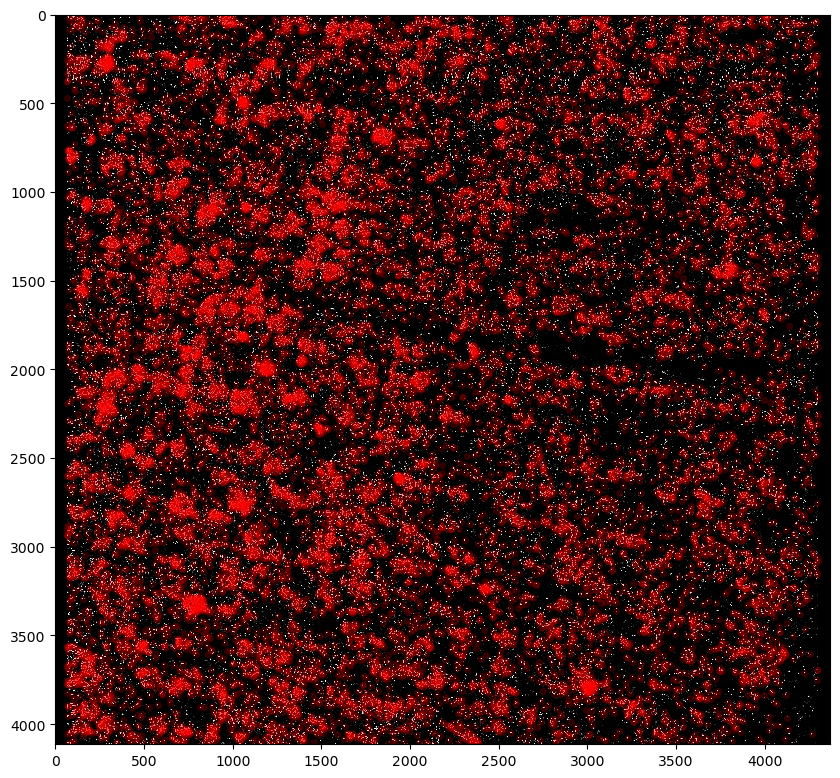

<Axes: >

In [37]:
# TODO Napari vis.
plt.rcParams["figure.figsize"] = (10, 10)
tp.annotate(spots, enhancded_anchor.get(), imshow_style={"vmin":0, "vmax":1000, }, plot_style={"markersize": 3, "alpha":0.2})

In [38]:
spots["x_int"] = spots["x"].astype(int)
spots["y_int"] = spots["y"].astype(int)

In [39]:
spots.to_csv(f"{root}/out/demo_optflow_seg_optflow_reg_result_stack_spots.csv",
            index=False)

In [40]:
enhanced_stack.shape

(24, 4114, 4369)

In [41]:
peak_profiles = enhanced_stack[:, spots["y_int"], spots["x_int"]]

In [42]:
peak_profiles.shape

(24, 19568)

In [43]:
reshaped_profiles = peak_profiles.reshape((4, 6, peak_profiles.shape[1])) # Reshape the peak profiles into a 4 barcodes * 6 cycles * 35 channels array

In [44]:
reshaped_profiles.shape

(4, 6, 19568)

In [47]:
first_profile = reshaped_profiles[:,:,0]
first_profile

array([[  0,   0,   5,   0,   4,   0],
       [  0,   6,   5,  14,   0, 272],
       [472,   0,   2,   3,   0,   0],
       [  0,   0,   0,   0,   0,   0]], dtype=uint16)

In [50]:
# Ont-hot encoding
first_profile.argmax(axis=0)

array([2, 1, 0, 1, 0, 1], dtype=int64)

In [51]:
# np.save(
#     f"{root}/out/demo_optflow_seg_optflow_reg_result_stack_peak_profiles.npy",
#     np.transpose(reshaped_profiles, (2, 0, 1)).astype(np.int32),
#     allow_pickle=True
# )

# Decoding - Codebook preprocessing

In [52]:
import bin.codebook_convert as cc
import bin.reading_data_functions as rdf
import bin.decode as dc
import pickle
import numpy as np

In [53]:
codebook_p = cc.main(f"{root}/in/NT_FLW mouse brain CNS codebook.xlsx", out_dir=f"{root}/out/")

OrderedDict([('Cy5', 'A'), ('AF488', 'G'), ('Cy3', 'C'), ('Atto425', 'T'), ('AF750', 'T')])
  nCycles nChannel    DAPI Cy5 AF488 Cy3 Atto425
0       6        5  nuclei   A     G   C       T
       Gene Channel
0      Ache  ACTTGA
1     Acta2  GTATCC
2     Aldoc  CCCATT
3      Bdnf  TTCGTC
4     Calca  AAACGT
5      Chat  CATAGG
6       Dcn  ATTCAG
7       Fev  TGCGAT
8       Fos  CTGCAC
9      Gad1  GTTTGA
10     Gad2  GATTCA
11     Gfap  ACAGCG
12     Gja1  CACTAT
13    Itgam  CTCGCG
14    Kcnj8  AGAGAT
15   Laptm5  CGTTAT
16     Map2  TCTTTG
17      Mbp  GCTCAC
18     Ndnf  CTACGT
19     Nefh  GCAATT
20  Neurod1  ATCCGA
21      Npy  ACCTAT
22    Npy2r  GTCCAC
23    Ntrk2  GGCGCA
24      Oxt  AGTGCT
25    P2rx3  CGAATT
26     Pcp4  CCTTCG
27     Pdyn  CGGACA
28     Plp1  ACGGTC
29    Ptprc  CAGCTC
30    Pvalb  ATGCCC
31   Rbfox3  GAGTGA
32  Slc17a6  GCGTCG
33  Slc17a7  TTTACA
34   Slc6a1  TACAGC
35   Slc6a3  TGAACC
36   Slc6a4  CTTCTG
37   Slc6a5  CCGTGG
38     Sncg  CAAACG
39     Spp

In [54]:
barcodes_01, K, R, C, gene_names, channels_info = rdf.read_taglist_and_channel_info(
        f"{root}/out/",
        taglist_name="taglist.csv",
        channel_info_name="channel_info.csv",
)

In [55]:
np.save(f"{root}/out/barcodes_01.npy", barcodes_01)
np.save(f"{root}/out/gene_names.npy", gene_names)
channels_info["K"] = K
channels_info["R"] = R
channels_info["C"] = C
print(channels_info)
with open(f"{root}/out/channel_info.pickle", "wb") as fp:
    pickle.dump(channels_info, fp)

{'barcodes_AGCT': array(['ACTTGA', 'GTATCC', 'CCCATT', 'TTCGTC', 'AAACGT', 'CATAGG',
       'ATTCAG', 'TGCGAT', 'CTGCAC', 'GTTTGA', 'GATTCA', 'ACAGCG',
       'CACTAT', 'CTCGCG', 'AGAGAT', 'CGTTAT', 'TCTTTG', 'GCTCAC',
       'CTACGT', 'GCAATT', 'ATCCGA', 'ACCTAT', 'GTCCAC', 'GGCGCA',
       'AGTGCT', 'CGAATT', 'CCTTCG', 'CGGACA', 'ACGGTC', 'CAGCTC',
       'ATGCCC', 'GAGTGA', 'GCGTCG', 'TTTACA', 'TACAGC', 'TGAACC',
       'CTTCTG', 'CCGTGG', 'CAAACG', 'CGCGGA', 'GGTCTG', 'GTGGTC',
       'TTATAC', 'AATATG', 'CCATAA', 'GGAAGC', 'TGTCGA', 'TATGAT'],
      dtype=object), 'coding_chs': [False, True, True, True, True], 'channel_base': ['nuclei', 'A', 'G', 'C', 'T'], 'channel_names': ['DAPI', 'Cy5', 'AF488', 'Cy3', 'Atto425'], 'K': 48, 'R': 6, 'C': 4}


In [56]:
dc.decode(
    "EMBL_training_mouse_brain",
    f"{root}/out/demo_optflow_seg_optflow_reg_result_stack_peak_profiles.npy",
    f"{root}/out/demo_optflow_seg_optflow_reg_result_stack_spots.csv",
    f"{root}/out/barcodes_01.npy", f"{root}/out/gene_names.npy", f"{root}/out/channel_info.pickle",
    out_dir=f"{root}/out/"
)

(19568, 4, 6)                        x          mass      size       ecc       signal  \
y                                                                         
2.241803      829.713764  15024.569562  1.187879  0.259268  2668.795951   
1.868121      969.936389  12287.003071  1.097451  0.053729  2658.191877   
2.107483     2087.951080   8829.918963  1.103736  0.108249  1890.332156   
2.226025     2861.095298  12218.700358  1.132915  0.184553  2313.091641   
1.868101     2979.977116  17540.386149  1.068302  0.144755  3770.216180   
...                  ...           ...       ...       ...          ...   
4110.591112   554.151063  14682.432229  1.193925  0.163194  2490.709882   
4110.858709  1043.694682  23588.139133  1.175160  0.387659  4231.805289   
4110.868927  1162.159815  13102.581126  1.197047  0.261695  2312.467872   
4110.990894  1788.570091  23049.514544  1.171605  0.432797  4193.911318   
4111.084381  3455.877532  11476.571112  1.159388  0.417885  2162.919238   

          

In [43]:
 ! ls "{root}/out/"

EMBL_training_mouse_brain_decode_out_parameters.pickle
EMBL_training_mouse_brain_decoded_df.tsv
barcodes_01.npy
channel_info.csv
channel_info.pickle
demo_optflow_seg_optflow_reg_result_stack_peak_profiles.npy
demo_optflow_seg_optflow_reg_result_stack_spots.csv
gene_names.npy
taglist.csv


# Visual QC of the decoded data

In [57]:
import pandas as pd
import napari

In [58]:
decoded_peaks = pd.read_csv(f"{root}/out/EMBL_training_mouse_brain_decoded_df.tsv", sep="\t")

In [59]:
decoded_peaks

,Name,Code,Probability,y_int,x_int,index_code,axis,R0_C0,R1_C0,R2_C0,...,R2_C2,R3_C2,R4_C2,R5_C2,R0_C3,R1_C3,R2_C3,R3_C3,R4_C3,R5_C3
0,Fos,CTGCAC,0.244985,2,829,132141.0,1,0,0,5,...,2,3,0,0,0,0,0,0,0,0
1,Slc6a3,TGAACC,0.282205,1,969,324411.0,1,0,0,0,...,2,0,0,9,898,5,0,0,0,0
2,Pdyn,CGGACA,0.713143,2,2087,122414.0,1,0,0,4,...,0,0,4,0,0,0,0,0,0,0
3,Slc17a7,TTTACA,0.923994,2,2861,333414.0,1,19,0,0,...,0,0,6,0,244,4,76,0,1,0
4,Ntrk2,GGCGCA,0.182876,1,2979,221214.0,1,3,0,0,...,5,7,17,37,2525,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19563,background,0000,0.962474,4110,554,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19564,background,0000,0.962474,4110,1043,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19565,background,0000,0.962474,4110,1162,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19566,background,0000,0.962474,4110,1788,NaN,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
decoded_group = decoded_peaks[decoded_peaks.Probability > 0.9]

In [61]:
decoded_peaks.Name.unique()

array(['Fos', 'Slc6a3', 'Pdyn', 'Slc17a7', 'Ntrk2', 'Laptm5',
       'background', 'Neurod1', 'infeasible', 'Oxt', 'Npy', 'Pvalb',
       'Calca', 'Chat', 'Npy2r', 'Kcnj8', 'P2rx3', 'Bdnf', 'Plp1', 'Sncg',
       'Gad2', 'Gad1', 'Ache', 'Sst', 'Slc6a4', 'Ndnf', 'Th', 'Acta2',
       'Slc6a5', 'Gfap', 'Syn1', 'Slc6a1', 'Rbfox3', 'Mbp', 'Ptprc',
       'Spp1', 'Vip', 'Itgam', 'Trpv1', 'Tph1', 'Tubb3', 'Nefh', 'Map2',
       'Dcn', 'Slc17a6', 'Gja1', 'Pcp4', 'Fev', 'Aldoc', 'Trh'],
      dtype=object)

In [62]:
decoded_group = decoded_peaks.groupby("Name")

In [ ]:
viewer = napari.Viewer()

/opt/conda/envs/EMBL_training/lib/python3.9/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


: 